In [46]:
import pandas as pd
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio import AlignIO, SeqIO
from collections import Counter
from Bio.Align import MultipleSeqAlignment
from random import shuffle
from copy import copy

In [47]:
hosts_18s = pd.read_csv('hosts_with_classification-NH_EM_mods.csv', index_col='Species')
hosts_18s.fillna(0, inplace=True)

In [48]:
# # I have manually curated the scientific name with Barcode of Life COI5P sequence data.
# from Bio.SeqRecord import SeqRecord
# from Bio.Seq import Seq
# from Bio.Alphabet import NucleotideAlphabet
# host_sequence = dict()
# for row, data in hosts_18s.iterrows():
#     host = row
#     if data['Sequence'] != 0:
#         sequence = Seq(str(data['Sequence']), alphabet=NucleotideAlphabet)
#         sequence = sequence.ungap('\n')
#         sequence = sequence.ungap(' ')
#         sequence = sequence.ungap('-')
#         sequence = sequence.ungap('\r')
#         id = '{0}'.format(row.replace(' ', '_'))
#         host_sequence[host] = SeqRecord(sequence, id=id, name=id, description=id)

In [49]:
# from Bio import SeqIO
# # Write the sequences to disk.
# SeqIO.write(host_sequence.values(), 'host_COI5P.fasta', 'fasta')
# # host_sequence

In [50]:
infile = 'host_COI_unaligned.fasta'
outfile = 'host_COI_aligned.fasta'

cline = ClustalOmegaCommandline(infile=infile, outfile=outfile, verbose=True, force=True)
print(cline)
# Run this from a separate terminal window. Should be fast <2 min on a modern computer.

clustalo -i host_COI_unaligned.fasta -o host_COI_aligned.fasta -v --force


In [51]:
coi5p_aln = AlignIO.read('host_COI_aligned.fasta', 'fasta')
coi5p_aln

<<class 'Bio.Align.MultipleSeqAlignment'> instance (105 records of length 1554, SingleLetterAlphabet()) at 11d14ae90>

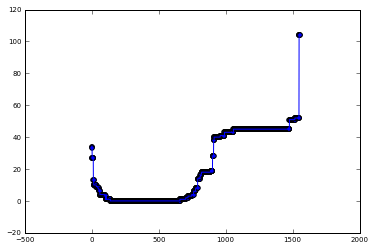

In [52]:

# Plot the number of gaps by position
# I will concatenate all positions that have zero gaps in them. This should span > 500 n.t.

num_gaps_threshold = 3

num_gaps = []
good_positions = []
for pos in range(coi5p_aln.get_alignment_length()):
    ntcounts = Counter(coi5p_aln[:,pos])
    if ntcounts['-'] < num_gaps_threshold:
        good_positions.append(pos)
    if '-' in ntcounts.keys():
        num_gaps.append(ntcounts['-'])
    else:
        num_gaps.append(0)
        
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
plt.scatter(range(len(num_gaps)), num_gaps)
plt.plot(num_gaps)

In [53]:
len(good_positions)

615

In [54]:
# Hacked code: iterate over every sequence, grab out only the letters in the good positions, and create new seqrecord.
trimmed_alignment_list = []
for s in coi5p_aln:
    trimmed_seq = ''
    for pos in good_positions:
        trimmed_seq += s[pos]
    trimmed_seq = Seq(trimmed_seq)
    trimmed_seqrecord = SeqRecord(trimmed_seq, id=s.id, description='')
    trimmed_alignment_list.append(trimmed_seqrecord)
    
trimmed_alignment = MultipleSeqAlignment(trimmed_alignment_list)

SeqIO.write(trimmed_alignment, 'host_COI5P_trimmed_alignment.fasta', 'fasta')
SeqIO.write(trimmed_alignment, 'host_COI5P_trimmed_alignment.phylip', 'phylip')

105

In [55]:
# Hacked code: for RaxML's purposes, iterate over every sequence in trimmed_alignment, replace apostrophy with 
raxml_seqs = []
for s in trimmed_alignment:
    new_s = copy(s)
    new_s.id = new_s.id.replace(' ', '_').replace("'",'|')
    raxml_seqs.append(new_s)
SeqIO.write(raxml_seqs, 'host_COI5P_trimmed_alignment_trees.fasta', 'fasta')

105

In [56]:
# Because the sequence data alignments are:
# 1. non-overlapping
# 2. highly variable in length,
# I think the best way to define distance is as such:
# - Compare every position in the alignment.
# - Increment distance by 1 if and only if both positions are not gaps and are different.
# - Normalize distance by taking distance/len(smaller_18S)

# Read in the alignment using AlignIO.
COI5P_sequences = AlignIO.read('host_COI5P_trimmed_alignment.fasta', 'fasta')

# Clean up the names in the dictionary keys so that they are 
# easily searchable.
host_sequence = dict()
for s in COI5P_sequences:
    host = s.id.replace('_', ' ')
    host_sequence[host] = s

host_sequence

{'American Black Duck': SeqRecord(seq=Seq('GCCTCTGATCCGGGCAGAACTAGGCCAGCCAGGGACCCTCCTGGGCGACGACCA...CGG', SingleLetterAlphabet()), id='American_Black_Duck', name='American_Black_Duck', description='American_Black_Duck', dbxrefs=[]),
 'American Green-Winged Teal': SeqRecord(seq=Seq('GCCTCTGATCCGGGCAGAACTAGGCCAGCCAGGGACCCTCCTGGGCGACGACCA...CGG', SingleLetterAlphabet()), id='American_Green-Winged_Teal', name='American_Green-Winged_Teal', description='American_Green-Winged_Teal', dbxrefs=[]),
 'American Wigeon': SeqRecord(seq=Seq('GCCTCTGATCCGGGCAGAACTAGGCCAGCCAGGGACCCTCCTGGGCGACGACCA...CGG', SingleLetterAlphabet()), id='American_Wigeon', name='American_Wigeon', description='American_Wigeon', dbxrefs=[]),
 'Baikal Teal': SeqRecord(seq=Seq('GCCTCTGATCCGGGCAGAACTAGGCCAGCCAGGGACCCTCCTGGGCGACGACCA...CGG', SingleLetterAlphabet()), id='Baikal_Teal', name='Baikal_Teal', description='Baikal_Teal', dbxrefs=[]),
 'Bar-Headed Goose': SeqRecord(seq=Seq('GCCTTTAATCCGCGCAGAACTAGGACAGCCAGGAACTCTCCTAGGCGA

In [57]:
# for j in range(len(host_sequence.keys())):
#     s1 = host_sequence[host_sequence.keys()[12]]
#     s2 = host_sequence[host_sequence.keys()[j]]

#     s1_ug = s1.seq.ungap('-')
#     s2_ug = s2.seq.ungap('-')

#     dist = 0
#     for i in range(len(s1)):
#         l1 = s1[i]
#         l2=  s2[i]

#         if l1 != '-' and l2 != '-' and l1 != l2:
#             dist += 1

#     print(dist / float(min([len(s1_ug), len(s2_ug)])))

In [58]:
# hosts_18s[hosts_18s['Genbank ID'] == host_sequence.keys()[19]]

In [59]:
import networkx as nx

G = nx.read_gpickle('20141103 All IRD Final Graph.pkl')

def clean_host_species(host_species):
    if '/' in host_species:
        host_species = host_species.split('/')[0]
        
    return host_species

def generate_random_polynucleotide(length):
    from random import choice
    from Bio.SeqRecord import SeqRecord
    from Bio.Seq import Seq
    polynt = ''
    for i in range(length):
        polynt = polynt + '-'
    seqrec = SeqRecord(Seq(polynt))
    return seqrec

# Add in the 18S rRNA sequence to each node, if available.
for n, d in G.nodes(data=True):
    host_species = clean_host_species(d['host_species'])
    
    if host_species in host_sequence.keys():
        G.node[n]['18s_rRNA_sequence'] = host_sequence[host_species]
    else:
        G.node[n]['18s_rRNA_sequence'] = generate_random_polynucleotide(COI5P_sequences.get_alignment_length())

In [60]:
G.node[n]

{'18s_rRNA_sequence': SeqRecord(seq=Seq('GCCTCTGATCCGGGCAGAACTAGGCCAGCCAGGGACCCTCCTGGGCGACGACCA...CGG', SingleLetterAlphabet()), id='Mallard', name='Mallard', description='Mallard', dbxrefs=[]),
 'collection_date': Timestamp('2008-11-22 00:00:00'),
 'country': 'Sweden',
 'host_species': 'Mallard/Avian',
 'subtype': 'H4N6'}

In [61]:
def compute_distance(seqrecord1, seqrecord2):
    smaller_length = min([len(seqrecord1.seq.ungap('-')), len(seqrecord2.seq.ungap('-'))])
    
    distance = 0
    for i in range(len(seqrecord1.seq)):
        l1 = seqrecord1.seq[i]
        l2 = seqrecord2.seq[i]
        
        if l1 != '-' and l2 != '-' and l1 != l2:
            distance += 1
            
    if smaller_length == 0:
        return 1
    else:
        return float(distance) / smaller_length
    
def compute_hamming_distance(seqrecord1, seqrecord2):
    """
    Computes the hamming distance between two seqrecords' sequences.
    """
    from Levenshtein import distance
    
    s1 = str(seqrecord1.seq)
    s2 = str(seqrecord2.seq)
    
    return distance(s1, s2) / float(len(seqrecord1.seq))

def host_phylogenetic_distance(G, n1, n2):
    """
    Compare two nodes' phylogenetic distance.
    """
    from Bio.SeqRecord import SeqRecord
    rrna_1 = G.node[n1]['18s_rRNA_sequence']
    rrna_2 = G.node[n2]['18s_rRNA_sequence']
    
    assert isinstance(rrna_1, SeqRecord), '{0} does not have a valid rRNA sequence.'.format(n1)
    assert isinstance(rrna_2, SeqRecord), '{0} does not have a valid rRNA sequence.'.format(n2)
    
    return compute_distance(rrna_1, rrna_2)

def host_hamming_distance(G, n1, n2):
    """
    Returns the hamming distnace between two seqrecords.
    """
    from Bio.SeqRecord import SeqRecord
    rrna_1 = G.node[n1]['18s_rRNA_sequence']
    rrna_2 = G.node[n2]['18s_rRNA_sequence']
    
    assert isinstance(rrna_1, SeqRecord), '{0} does not have a valid rRNA sequence.'.format(n1)
    assert isinstance(rrna_2, SeqRecord), '{0} does not have a valid rRNA sequence.'.format(n2)

    return compute_hamming_distance(rrna_1, rrna_2)

(0.2032520325203252, 'Swine', 'Human')


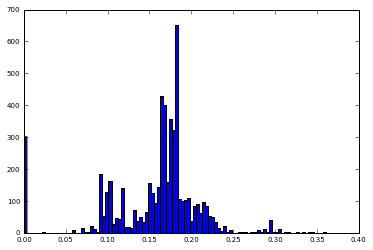

In [62]:
from itertools import combinations

distances = []
for (h1, s1), (h2, s2) in combinations(host_sequence.items(), 2):
    if ('Human' in s1.description or 'Human' in s2.description) and ('Swine' in s1.description or 'Swine' in s2.description):
        print(compute_distance(s1, s2),  s1.description, s2.description)
    
    # distances.append(compute_distance(s1,s2))
    distances.append(compute_hamming_distance(s1, s2))
    
plt.hist(distances, bins=100)
plt.show()

In [63]:
G.edges(data=True)[0]

('A/mallard/Interior Alaska/6MP0160AR1/2006',
 'A/green-winged teal/Interior Alaska/6MP1077/2006',
 {'edge_type': 'full_complement',
  'pwi': 7.7231860000000001,
  'segments': {1: 0.99085800000000002,
   2: 0.88994799999999996,
   3: 0.90987300000000004,
   4: 0.99942500000000001,
   5: 0.93408000000000002,
   6: 1.0,
   7: 0.99900199999999995,
   8: 1.0}})

In [64]:
# Compute distribution of phylo distances across reassortant vs. whole genome edges.
# Perform 2-sample KS test to see if they are different.
# Ignore the following:

def count_delta_phyloD(G):
    """
    Computes the distribution of phylogenetic distances across every edge
    in a graph.
    """
    reassortant_phyloD = []
    full_complement_phyloD = []

    for sc, sk, d in G.edges(data=True):
        sc_18s = G.node[sc]['18s_rRNA_sequence'].seq.ungap('-')
        sk_18s = G.node[sk]['18s_rRNA_sequence'].seq.ungap('-')

        if len(sc_18s) != 0 and len(sk_18s) != 0:
            dist = host_hamming_distance(G, sc, sk)
            if d['edge_type'] == 'reassortant':
                reassortant_phyloD.append(dist)

            elif d['edge_type'] == 'full_complement':
                full_complement_phyloD.append(dist)
                
    return reassortant_phyloD, full_complement_phyloD

In [65]:
reassortant_phyloD, full_complement_phyloD = count_delta_phyloD(G)

In [66]:
reassortant_phyloD

[0.0,
 0.0,
 0.0,
 0.0,
 0.2048780487804878,
 0.2048780487804878,
 0.2048780487804878,
 0.2048780487804878,
 0.2048780487804878,
 0.17560975609756097,
 0.2048780487804878,
 0.2048780487804878,
 0.2048780487804878,
 0.2048780487804878,
 0.2048780487804878,
 0.16260162601626016,
 0.0,
 0.0,
 0.09268292682926829,
 0.0,
 0.0,
 0.17560975609756097,
 0.0,
 0.0,
 0.0,
 0.0,
 0.17560975609756097,
 0.0,
 0.0,
 0.0,
 0.1024390243902439,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.09268292682926829,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.16260162601626016,
 0.16260162601626016,
 0.16260162601626016,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2016260162601626,
 0.0,
 0.0,
 0.0,
 0.11707317073170732,
 0.0,
 0.2016260162601626,
 0.0,
 0.0,
 0.2048780487804878,
 0.0,
 0.14308943089430895,
 0.2016260162601626,
 0.2016260162601626,
 0.2016260162601626,
 0.20162601

In [67]:
len(reassortant_phyloD)

import numpy as np

bins = np.arange(0,0.51,0.05)

reassortant_binned = np.histogram(reassortant_phyloD, bins=bins)[0].astype(float)
full_complement_binned = np.histogram(full_complement_phyloD, bins=bins)[0].astype(float)

full_complement_binned.shape

(10,)

In [68]:
reassortant_binned

array([ 3006.,    89.,   162.,   585.,   667.,     0.,     0.,     0.,
           0.,     0.])

In [94]:
xpoints = np.arange(0,0.50,0.05)
xpoints.shape

(10,)

In [95]:
proportion_reassortant = reassortant_binned / (full_complement_binned + reassortant_binned)
proportion_reassortant

array([ 0.16900933,  0.65925926,  0.53114754,  0.58971774,  0.51745539,
        0.        ,         nan,         nan,         nan,         nan])

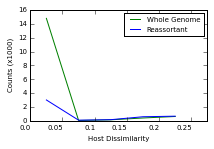

In [107]:
fig = plt.figure(figsize=(3,2))

ax1 = fig.add_subplot(111)
ax1.plot(xpoints[0:5], full_complement_binned[0:5], color='green', label='Whole Genome')
ax1.plot(xpoints[0:5], reassortant_binned[0:5], color='blue', label='Reassortant')
ax1.set_ylabel('Counts (x1000)')
ax1.set_xlabel('Host Dissimilarity')
ax1.set_xticks(xpoints - 0.025)
ax1.set_xticklabels(xpoints, rotation=0, ha='right')
ax1.set_xlim(-0.025, 0.25)
ax1.set_yticklabels(np.arange(0, 17, 2))
ax1.legend()
plt.subplots_adjust(left=0.13, bottom=0.18, right=0.95, top=0.95)
plt.savefig('PhyloD Edges Per Bin.pdf')

In [72]:
# # Chi-squared test. Groups are:
# #                  | 18S same | 18S diff|
# # ---------------------------------------
# # reassortant      |    1     |    2    |
# # ---------------------------------------
# # non-reassortant  |    3     |    4    |

# from scipy.stats import chi2_contingency

# data = np.zeros((2,2))
# data[0,0] = Counter(reassortant_phyloD)[0]
# data[0,1] = sum([v for k, v in Counter(reassortant_phyloD).items() if k != 0])
# data[1,0] = Counter(full_complement_phyloD)[0]
# data[1,1] = sum([v for k, v in Counter(full_complement_phyloD).items() if k != 0])
# from scipy.stats import chi2_contingency
# chi2_contingency(data) 


In [73]:
# len(full_complement_phyloD)

In [74]:
# from scipy.stats import ks_2samp

# ks_2samp(sorted(reassortant_phyloD), full_complement_phyloD)
# ks_2samp(sorted(full_complement_phyloD), reassortant_phyloD)

In [75]:
# # Define the "proportion non-identical" over all reassortant and full_complement edges. 

# def proportion_nonidentical(list_of_phyloD_values):
#     return 1 - float(Counter(list_of_phyloD_values)[0.0]) / sum(Counter(list_of_phyloD_values).values())
# proportion_nonidentical(reassortant_phyloD)

In [76]:
# proportion_nonidentical(full_complement_phyloD)

In [77]:
# ratio = proportion_nonidentical(reassortant_phyloD)/proportion_nonidentical(full_complement_phyloD)
# # pd.DataFrame([ratio]).to_csv('ratio_identical_nonidentical.csv')

30 April 2015

Reassortment is more highly represented when there is a phylogenetic difference between the host species than when there isn't.

Phylogenetic difference is defined by the 18S rRNA. 

What if we used cytochrome C oxidase?

In [78]:
np.shape(bins)

(11,)

In [79]:
def permute_18s(G):
    """
    Be sure to pass in a copy of G, and not the original!
    Takes in a graph G, shuffles the labels, and returns G with shuffled labels.
    """
    from random import shuffle
    rrna_labels = [d['18s_rRNA_sequence'] for n, d in G.nodes(data=True)]
    shuffle(rrna_labels)
    
    for i, n in enumerate(G.nodes()):
        G.node[n]['18s_rRNA_sequence'] = rrna_labels[i]
        
    return G

shuffledG = G.copy()

expected_reassort = []

from time import time

data = np.zeros(shape=(100, 10))

In [80]:
for i in range(100): # changed to 100 in script format.
    start_time = time()
    shuffledG = permute_18s(shuffledG)
    reassortant_shuffled_phyloD, full_complement_shuffled_phyloD = count_delta_phyloD(shuffledG)
    
    reassortant_shuffled_binned = np.histogram(reassortant_shuffled_phyloD, bins=bins)[0].astype(float)
    full_complement_shuffled_binned = np.histogram(full_complement_shuffled_phyloD, bins=bins)[0].astype(float)
    
    expected_proportion_reassortant = reassortant_shuffled_binned / (full_complement_shuffled_binned + reassortant_shuffled_binned)
    
    end_time = time()
    
    data[i] = expected_proportion_reassortant
    
    print('Round {0}, time: {1} s'.format(i, end_time - start_time))

Round 0, time: 13.2903928757 s
Round 1, time: 12.7625517845 s
Round 2, time: 12.2676510811 s
Round 3, time: 13.0683209896 s
Round 4, time: 13.1097400188 s
Round 5, time: 15.6066989899 s
Round 6, time: 13.0478880405 s
Round 7, time: 12.5526161194 s
Round 8, time: 14.6448049545 s
Round 9, time: 16.3178460598 s
Round 10, time: 15.452340126 s
Round 11, time: 13.1368751526 s
Round 12, time: 15.52760005 s
Round 13, time: 13.7950949669 s
Round 14, time: 14.5813291073 s
Round 15, time: 13.9751191139 s
Round 16, time: 14.9257848263 s
Round 17, time: 14.5043787956 s
Round 18, time: 14.0716528893 s
Round 19, time: 13.3281598091 s
Round 20, time: 13.491453886 s
Round 21, time: 13.4614150524 s
Round 22, time: 15.3799347878 s
Round 23, time: 13.138094902 s
Round 24, time: 11.1203300953 s
Round 25, time: 11.2392368317 s
Round 26, time: 11.3123440742 s
Round 27, time: 10.6517779827 s
Round 28, time: 10.9149119854 s
Round 29, time: 10.7620289326 s
Round 30, time: 10.553360939 s
Round 31, time: 10.51669

/Users/ericmjl/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:476: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


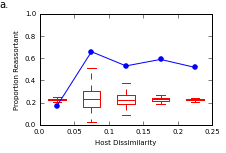

In [81]:
# pd.DataFrame(data).fillna(0).to_csv('phylod_expected_reassortant_fraction.csv')

# Read in the data from running the above cells on Rous.
expected_shuffled = pd.read_csv('phylod_expected_reassortant_fraction.csv', index_col=0)
expected_shuffled = expected_shuffled[['0', '1', '2', '3', '4']]
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)

bp = ax.boxplot(expected_shuffled.values, showfliers=False)
plt.setp(bp['boxes'], color='red')
plt.setp(bp['whiskers'], color='red')
plt.setp(bp['fliers'], color='red')
plt.setp(bp['caps'], color='red')
plt.setp(bp['medians'], color='red')

xpoints = np.arange(1, 11, 1)
ax.scatter(xpoints[0:5], proportion_reassortant[0:5], color='blue')
ax.plot(xpoints[0:5], proportion_reassortant[0:5], color='blue')
ax.set_ylabel('Proportion Reassortant')
ax.set_ylim(0, 1)
ax.set_xlabel('Host Dissimilarity')
ax.set_xlim(0.5,5)
ax.set_xticks(np.arange(0,6,1)+0.5)
ax.set_xticklabels(np.arange(0,0.3,0.05))

lines, labels = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend() 
ax.annotate('a.', xy=(0,1), xycoords='figure fraction', ha='left', va='top')

plt.subplots_adjust(left=0.15, bottom=0.18, right=0.95, top=0.95)
plt.savefig('Phylogenetic Susceptibility and Reassortment.pdf')

In [82]:
# # Plot proportion non-identical vs. identical ratio
# import numpy as np
# simulated = pd.read_csv('ratio_identical_nonidentical_expected.csv', index_col=0)
# actual = pd.read_csv('ratio_identical_nonidentical.csv', index_col=0)

# mean = simulated.mean().values
# ci99 = simulated.std() * 3
# ci99 = ci99.values

# barwidth = 0.3

# fig = plt.figure(figsize=(1, 1.5))
# ax = fig.add_subplot(111)
# ax.bar(1, mean, width=barwidth, yerr=ci99, color='blue', alpha=0.5, label='Shuffled')
# ax.bar(1-barwidth, actual.values, width=barwidth, color='blue', label='Data')
# ax.set_ylabel('Fold Representation')
# ax.set_xticks([])
# ax.set_yticks(np.arange(0,5,1))
# ax.annotate('b.', xy=(0,1), xycoords='figure fraction', ha='left', va='top')
# plt.subplots_adjust(left=0.3, bottom=0.05)
# plt.savefig('PhyloD Reassortant Fold Over-Representation.pdf')

In [83]:
# Plot viral PWD against host PWD
viral_pwd_reassortant = []
viral_pwd_full = []
host_pwd_reassortant = []
host_pwd_full = []
# edge_reassortant_status = []
for sc, sk, d in G.edges(data=True):
    sc_18s = G.node[sc]['18s_rRNA_sequence'].seq.ungap('-')
    sk_18s = G.node[sk]['18s_rRNA_sequence'].seq.ungap('-')

    if len(sc_18s) != 0 and len(sk_18s) != 0:
        dist = host_phylogenetic_distance(G, sc, sk)
        
    #viral_pwd.append(d['pwi'])
    #host_pwd.append(dist)
    if d['edge_type'] == 'full_complement':
        viral_pwd_full.append(d['pwi'])
        host_pwd_full.append(dist)
    if d['edge_type'] == 'reassortant':
        viral_pwd_reassortant.append(d['pwi'])
        host_pwd_reassortant.append(dist)

In [84]:
print(8 - np.mean(viral_pwd_reassortant))
print(8 - np.mean(viral_pwd_full))

0.226099081401
0.0464142040183


In [85]:
print(np.mean(host_pwd_reassortant))
print(np.mean(host_pwd_full))

0.0503723822143
0.014724307049


In [86]:
(sum(Counter(host_pwd_full).values()) - Counter(host_pwd_full)[0]) / float(Counter(host_pwd_full)[0])

0.09120581352383299

In [87]:
(sum(Counter(host_pwd_reassortant).values()) - Counter(host_pwd_reassortant)[0]) / float(Counter(host_pwd_reassortant)[0])

0.40456382220109344

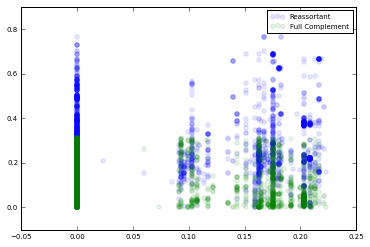

In [88]:
# plt.hist2d
from matplotlib.colors import LogNorm 

fig = plt.figure()#figsize=(3,2))
ax = fig.add_subplot(111)
ax.scatter(host_pwd_reassortant, 8 - np.array(viral_pwd_reassortant), color='blue', label='Reassortant', alpha=0.1)
ax.scatter(host_pwd_full, 8 - np.array(viral_pwd_full), color='green', label='Full Complement', alpha=0.1)
ax.legend()

In [89]:
from scipy.stats import linregress

slope_r, intercept_r, r_value_r, p_value_r, std_error_r = linregress(8 - np.array(viral_pwd_reassortant), host_pwd_reassortant)
slope_f, intercept_f, r_value_f, p_value_f, std_error_f = linregress(8 - np.array(viral_pwd_full), host_pwd_full)

In [90]:
print(slope_r, slope_f)
print(r_value_r**2, r_value_f**2)
print(p_value_r, p_value_f)
print(std_error_r, std_error_f)

(0.18744734375693342, 0.067122698996755603)
(0.093335328930921724, 0.011255433069242701)
(7.068270051519118e-128, 1.5941162795570203e-45)
(0.0076014443552428479, 0.0047264521845553414)


(array([  4.20700000e+03,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   2.01000000e+02,   3.40000000e+01,
          5.60000000e+01,   5.78000000e+02,   1.27000000e+02,
          7.03000000e+02]),
 array([ 0.        ,  0.02227642,  0.04455285,  0.06682927,  0.08910569,
         0.11138211,  0.13365854,  0.15593496,  0.17821138,  0.2004878 ,
         0.22276423]),
 <a list of 10 Patch objects>)

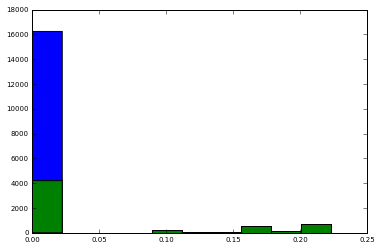

In [91]:
# plt.scatter([0] * len(host_pwd_full), host_pwd_full, alpha=0.1, color='green')
# plt.scatter([1] * len(host_pwd_reassortant), host_pwd_reassortant, alpha=0.1, color='blue')
plt.hist(host_pwd_full)
plt.hist(host_pwd_reassortant)

In [92]:
# Add in ecotype information

# Load the data
df = pd.read_csv('Country-Species_to_be_Coded_by_Nichola.csv', index_col=0)
df['Habitat/setting'] = df['Habitat/setting'].replace('Domestic ', 'Domestic')
# Make it into a dicitonary where each entry is (country, species):habitat/setting
ecotype_map = dict()

for row, data in df.iterrows():
    country = data['Country']
    species = data['Species']
    ecotype = data['Habitat/setting']

    ecotype_map[(country, species)] = ecotype

# Add the ecotype into each node.
for n, d in G.nodes(data=True):
    country = d['country']
    species = d['host_species']
    if '/' in species:
        species = species.split('/')[0]
    if 'null' in species:
        species = 'Unknown'


    
    G.node[n]['ecotype'] = ecotype_map[(country, species)]

KeyError: ('Romania', 'Horse')

In [ ]:
def correct_metadata(G, node):
    """
    Helper function for providing the correct subtype graph metadata.    
    """
    d = G.node[node]
    subtype = d['subtype']
    ecotype = d['ecotype']
    host = d['host_species']
    if ecotype == 'Unknown':
        ecotype = 'W'
    if host == 'Human':
        ecotype = 'H'
    if ecotype == 'Domestic':
        ecotype = 'D'
    if ecotype == 'Wild':
        ecotype = 'W'
    subtype = subtype + '::' + ecotype
    
    return ecotype, subtype, host
    

In [ ]:
from collections import Counter, defaultdict
transition_hostpd_reassortant = defaultdict(list)
transition_hostpd_full = defaultdict(list)
# Plot the number of ecotype jumps detected.
for sc, sk, d in G.edges(data=True):
    sc_ecotype, sc_subtype, sc_host = correct_metadata(G, sc)
    sk_ecotype, sk_subtype, sk_host = correct_metadata(G, sk)

    sc_18s = G.node[sc]['18s_rRNA_sequence'].seq.ungap('-')
    sk_18s = G.node[sk]['18s_rRNA_sequence'].seq.ungap('-')


    transition = sc_ecotype + '::' + sk_ecotype
    if len(sc_18s) != 0 and len(sk_18s) != 0:
        dist = host_phylogenetic_distance(G, sc, sk)
        if d['edge_type'] == 'reassortant':
            transition_hostpd_reassortant[transition].append(dist)
        else:
            transition_hostpd_full[transition].append(dist)

In [ ]:
transition_hostpd_means = defaultdict(list)
for k, v in transition_hostpd.items():
    transition_hostpd_means[k] = np.mean(v)

fig = plt.figure()
ax = fig.add_subplot(111)
# ax.bar(np.arange(len(transition_hostpd_means.keys()))-0.5, transition_hostpd_means.values())
# ax.set_xticks(np.arange(len(transition_hostpd_means.keys())))
# ax.set_xticklabels(transition_hostpd_means.keys())
dataset = sorted(transition_hostpd_reassortant.items(), key=lambda x:x[0])
compiled = []
for i, (transition, hostpds) in enumerate(dataset):
    #np.array(hostpds)
    compiled.append(np.array(hostpds))
    print(len(np.array(hostpds)))
    ax.scatter([i] * len(hostpds), hostpds, alpha=0.1, color='blue')
    
dataset = sorted(transition_hostpd_full.items(), key=lambda x:x[0])
compiled = []
for i, (transition, hostpds) in enumerate(dataset):
    #np.array(hostpds)
    compiled.append(np.array(hostpds))
    print(len(np.array(hostpds)))
    ax.scatter([i] * len(hostpds), hostpds, alpha=0.1, color='green')
    



In [ ]:
# Try tree patristic distance rather than hamming distance.
import dendropy as dp

tree = dp.Tree().get_from_path('RAxML_bestTree.host_COI5P_trimmed_alignment.nexus', 'nexus')

pds = dp.treecalc.PatristicDistanceMatrix(tree).distances()

In [ ]:
taxon_dict = {str(i).split(': ')[-1]:i for i in tree.taxon_set}
taxon_dict

In [ ]:
network_pds = dict()
network_pds['reassortant'] = list()
network_pds['full_complement'] = list()

for sc, sk, d in G.edges(data=True):
    sc_host = G.node[sc]['host_species']
    sk_host = G.node[sk]['host_species']
    if sc_host in taxon_dict.keys() and sk_host in taxon_dict.keys():
        patr_dist = dp.treecalc.patristic_distance(tree, taxon_dict[sc_host], taxon_dict[sk_host])
        network_pds[d['edge_type']].append(patr_dist)

In [ ]:
plt.hist(network_pds['reassortant'])

In [ ]:
plt.hist(network_pds['full_complement'])